In [1]:
import numpy as np
import pyro.distributions as dist
import torch
import pyro
import matplotlib.pyplot as plt
import model_mobster_mv_orfeo_generative as mobster_mv 
from utils.BoundedPareto import BoundedPareto
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns


%load_ext autoreload
%autoreload 2

c:\Users\Standard\miniconda3\envs\mobsterh\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [60]:
tot = []
a = torch.tensor([1,2,3])
tot.append(a)
b = torch.tensor([4,5,6])
tot.append(b)
c = torch.tensor([7,8,9])
tot.append(c)
torch.cat(tot)

tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])

### N = 1000, n_clusters (in each dimension) = 3 

torch.Size([1000, 2])
torch.Size([1000, 2])


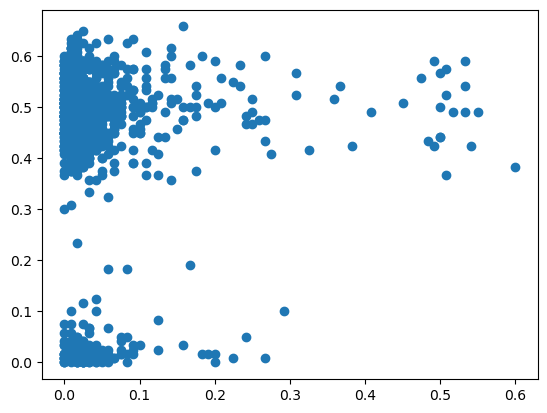

In [74]:
# Pareto-Binomial
def pareto_binomial(N, alpha, L, H, depth):
    p = BoundedPareto(scale=L, alpha=alpha, upper_limit=H).sample((N,))
    return dist.Binomial(total_count=depth, probs=p).sample()

# Beta-Binomial
def beta_binomial(N, phi, kappa, depth):
    a = phi*kappa
    b = (1-phi)*kappa
    p = dist.Beta(a, b).sample((N,))
    return dist.Binomial(total_count=depth, probs=p).sample()


def generate_data(N, K, pi):
    NV = []
    labels = []
    type_labels = []
    param_list = []
    # depth = torch.randint(80, 150, (N,))  # Random depth
    depth = torch.tensor(120).repeat((N,))

    for k in range(K):
        # Pareto-Binomial for one cluster in each dimension
        if k == 0:
            alpha = torch.tensor(1.0)  # Pareto shape parameter
            pareto_L = torch.tensor(0.01)  # scale Pareto
            pareto_H = torch.tensor(0.5)  # Upper bound Pareto
            NV.append(pareto_binomial(pi[k], alpha, pareto_L, pareto_H, depth[:pi[k]]))
            labels.extend([k] * pi[k])
            type_labels.extend(['P'] * pi[k])
            param_list.extend([1.] * pi[k])
        elif k == 1:
            # Beta-Binomial in 0.5
            kappa = 200.
            phi = 0.5
            NV.append(beta_binomial(pi[k], phi, kappa, depth[pi[k-1]:(pi[k-1]+pi[k])]))
            labels.extend([k] * pi[k])
            type_labels.extend(['B'] * pi[k])
            param_list.extend([phi] * pi[k])
        else:
            # Beta-Binomial in [0.15, 0.45]
            kappa = 200.
            phi_L, phi_H = 0.15, 0.4
            phi = dist.Uniform(phi_L, phi_H).sample()
            NV.append(beta_binomial(pi[k], phi, kappa, depth[pi[k-1]:(pi[k-1]+pi[k])]))
            labels.extend([k] * pi[k])
            type_labels.extend(['B'] * pi[k])
            param_list.extend([round(phi.item(), 3)] * pi[k])
    
    NV = torch.cat(NV)
    labels = torch.tensor(labels)
    return NV, depth, labels, type_labels, param_list

N = 1000  # number of samples
K1 = 2    # number of clusters in dim 1
K2 = 2   # number of clusters in dim 2

pi_x = dist.Dirichlet(torch.ones(K1)).sample() * N # number of data in each cluster for dim 1
pi_x = np.round(pi_x.numpy()).astype('int')
if(np.sum(pi_x) < N):
    pi_x[-1] = pi_x[-1]+1
if(np.sum(pi_x) > N):
    pi_x[-1] = pi_x[-1]-1


pi_y = dist.Dirichlet(torch.ones(K2)).sample() * N # number of data in each cluster for dim 2
pi_y = np.round(pi_y.numpy()).astype('int')
if(np.sum(pi_y) < N):
    pi_y[-1] = pi_y[-1]+1
if(np.sum(pi_y) > N):
    pi_y[-1] = pi_y[-1]-1

pi_z = dist.Dirichlet(torch.ones(K2)).sample() * N # number of data in each cluster for dim 2
pi_z = np.round(pi_z.numpy()).astype('int')
if(np.sum(pi_z) < N):
    pi_z[-1] = pi_z[-1]+1
if(np.sum(pi_z) > N):
    pi_z[-1] = pi_z[-1]-1
# pi_x = torch.tensor([0.4, 0.3, 0.3])
# pi_y = torch.tensor([0.5, 0.25, 0.25])

NV_x, DP_x, labels_x, type_labels_x, param_list_x = generate_data(N, K1, pi_x)
NV_y, DP_y, labels_y, type_labels_y, param_list_y = generate_data(N, K2, pi_y)

NV = torch.stack((NV_x, NV_y), dim = 0).T
print(NV.shape)

DP = torch.stack((DP_x, DP_y), dim = 0).T
print(DP.shape)
plt.scatter(NV[:,0].numpy()/DP[:,0].numpy(), NV[:,1].numpy()/DP[:,1].numpy())

Unique cluster combinations: 
 tensor([[0, 0],
        [0, 1],
        [1, 1]])
True K:  3
cluster weights:  tensor([0.1450, 0.8390, 0.0160])
Corresponding types for unique combinations: 
 [['P', 'P'], ['P', 'B'], ['B', 'B']]


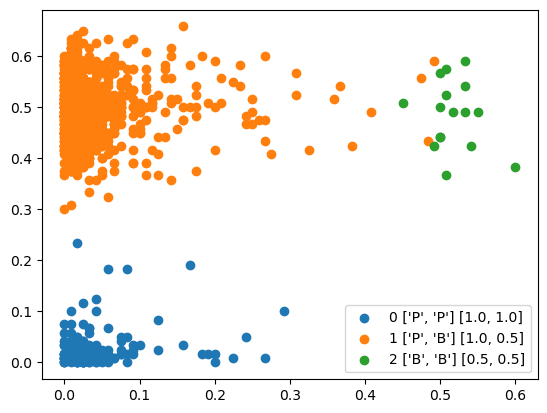

In [75]:
combined_labels = torch.stack((labels_x, labels_y), dim=1)
unique_combinations, cluster_ids = torch.unique(combined_labels, return_inverse=True, dim=0)

print(f"Unique cluster combinations: \n {unique_combinations}")
# print(f"Clusters: {cluster_ids}")

# Count occurrences of each unique cluster combination using cluster_ids
cluster_counts = torch.bincount(cluster_ids)
print("True K: ", len(cluster_counts))
cluster_proportions = cluster_counts.float() / N
print("cluster weights: ", cluster_proportions)


unique_types = []
for combo in unique_combinations:
    x_index = (labels_x == combo[0]).nonzero(as_tuple=True)[0][0].item()  # Find index in labels_x
    y_index = (labels_y == combo[1]).nonzero(as_tuple=True)[0][0].item()  # Find index in labels_y
    unique_types.append([type_labels_x[x_index], type_labels_y[y_index]])

unique_params = []
for combo in unique_combinations:
    x_index = (labels_x == combo[0]).nonzero(as_tuple=True)[0][0].item()  # Find index in labels_x
    y_index = (labels_y == combo[1]).nonzero(as_tuple=True)[0][0].item()  # Find index in labels_y
    unique_params.append([param_list_x[x_index], param_list_y[y_index]])

print(f"Corresponding types for unique combinations: \n {unique_types}")

for i, cluster in enumerate(unique_combinations):
    mask = (cluster_ids == i)  # Mask for current cluster
    plt.scatter(NV[mask, 0].numpy() / DP[mask, 0].numpy(), 
                NV[mask, 1].numpy() / DP[mask, 1].numpy(), 
                label=f'{i} {unique_types[i]} {unique_params[i]}')
plt.legend(loc='best')
plt.show()

In [77]:
seed_list = [40]
true_K = len(cluster_counts)
K_list = [true_K - 1, true_K, true_K + 1]
mb, best_K, best_seed = mobster_mv.fit(NV, DP, num_iter = 2000, K = K_list, seed = seed_list, lr = 0.005)

No GPU available. Training will run on CPU.
RUN WITH K = 2 AND SEED = 40
NV = 0 before: tensor(136)
NV = 0 after: tensor(136)
Iteration 0: Loss = 24174067.607712984
Iteration 200: Loss = 13832190.636770785
Iteration 400: Loss = 10251140.23700571
Iteration 600: Loss = 8953288.103389263
Iteration 800: Loss = 8307110.183069408
Iteration 1000: Loss = 7843104.092000127
Iteration 1200: Loss = 7446962.535971284
Iteration 1400: Loss = 7080403.355189025
Iteration 1600: Loss = 6937802.986294866
Iteration 1800: Loss = 6897410.490323484
Inference lk:  -6950.517
Final lk (integr):  tensor(-6494.3438, grad_fn=<SumBackward0>)
INTEGR: 
bic: 13223.55078125 

icl: 13225.798828125 

RUN WITH K = 3 AND SEED = 40
NV = 0 before: tensor(136)
NV = 0 after: tensor(136)
Iteration 0: Loss = 23740356.9778378
Iteration 200: Loss = 12922607.665865421
Iteration 400: Loss = 9361768.637350082
Iteration 600: Loss = 8087864.108393431
Iteration 800: Loss = 7520420.497182608
Iteration 1000: Loss = 7221018.585426807
Iterat

In [78]:
from sklearn.metrics import adjusted_rand_score
print(cluster_ids.shape)
print(mb.params["cluster_assignments"].shape)
true_labels = cluster_ids
predicted_labels = mb.params["cluster_assignments"]

nmi_score = normalized_mutual_info_score(true_labels, predicted_labels)
ari = adjusted_rand_score(true_labels, predicted_labels)
print(f"Normalized Mutual Information (NMI): {nmi_score:.4f}")
print(f"Adjusted Rand Index (ARI): {ari}")

torch.Size([1000])
torch.Size([1000])
Normalized Mutual Information (NMI): 0.8847
Adjusted Rand Index (ARI): 0.9199081861700384


In [79]:
print(cluster_proportions)
print(mb.params["weights_param"])

tensor([0.1450, 0.8390, 0.0160])
tensor([0.8610, 0.1390], dtype=torch.float64, grad_fn=<DivBackward0>)


In [80]:
print(unique_types)
true_dist = np.array([[0. if elem == 'P' else 1. for elem in sublist] for sublist in unique_types])
true_dist

[['P', 'P'], ['P', 'B'], ['B', 'B']]


array([[0., 0.],
       [0., 1.],
       [1., 1.]])

In [81]:
delta = mb.params["delta_param"]
pred_dist = np.zeros((mb.K, mb.NV.shape[1]))
for k in range(mb.K):
    for d in range(mb.NV.shape[1]):
        delta_kd = delta[k, d]
        maxx = torch.argmax(delta_kd)
        if maxx == 0: # Pareto
            pred_dist[k,d] = 0
        else:
            pred_dist[k,d] = 1
print(delta)
print(pred_dist)

tensor([[[0.5415, 0.4585],
         [0.0133, 0.9867]],

        [[0.5464, 0.4536],
         [0.9867, 0.0133]]], grad_fn=<DivBackward0>)
[[0. 1.]
 [0. 0.]]


In [86]:
print(true_dist.flatten(), pred_dist.flatten())

[0. 0. 0. 1. 1. 1.] [0. 1. 0. 0.]


In [84]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Confusion matrix
conf_matrix = confusion_matrix(true_dist.flatten(), pred_dist.flatten(), labels=[0, 1])
print("Confusion Matrix:")
print(conf_matrix)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report with precision, recall, F1-score, and accuracy
print("\nClassification Report:")
print(classification_report(true_dist, pred_dist, target_names=['Pareto', 'Beta']))

# Accuracy score
accuracy = accuracy_score(true_dist, pred_dist)
print(f"\nAccuracy: {accuracy:.4f}")


ValueError: Found input variables with inconsistent numbers of samples: [3, 2]

### Check

In [26]:
a = []
a.append(['b', 'b'])
a

[['b', 'b']]

tensor([0.0416, 0.3853, 0.0982, 0.1509, 0.3240])
tensor([ 41.5925, 385.3120,  98.1909, 150.8664, 324.0383])


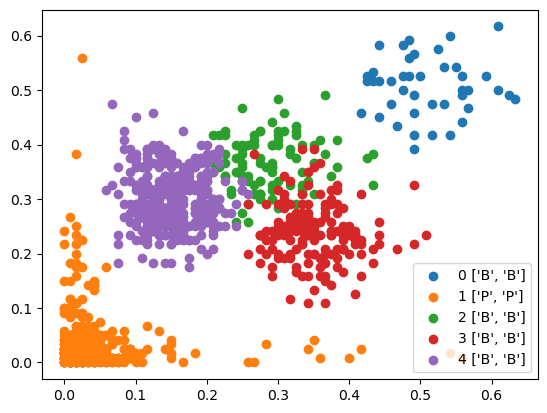

In [5]:
import torch
import torch.distributions as dist
import matplotlib.pyplot as plt

# Define the Pareto-Binomial function
def pareto_binomial(N, alpha, L, H, depth):
    p = BoundedPareto(scale=L, alpha=alpha, upper_limit=H).sample((N,))
    return dist.Binomial(total_count=depth, probs=p).sample()

# Define the Beta-Binomial function
def beta_binomial(N, phi, kappa, depth):
    a = phi * kappa
    b = (1 - phi) * kappa
    p = dist.Beta(a, b).sample((N,))
    return dist.Binomial(total_count=depth, probs=p).sample()

# Modify the data generation function to sample 2D datasets directly
def generate_data_2d(N, K, pi):
    NV_x = []
    NV_y = []
    labels = []
    type_labels = []
    type_labels_single = []
    param_list = []
    
    depth = torch.tensor(120).repeat((N,))  # Fixed depth

    # Always have a Beta-Binomial component with phi=0.5
    kappa = 200.
    NV_x.append(beta_binomial(pi[0], 0.5, kappa, depth[:pi[0]]))
    NV_y.append(beta_binomial(pi[0], 0.5, kappa, depth[:pi[0]]))
    labels.extend([0] * pi[0])
    type_labels.extend([['B','B']] * pi[0])
    type_labels_single.append(['B','B'])
    # param_list.extend([0.5] * pi[0])

    # Always have a Pareto-Binomial component
    alpha = torch.tensor(1.0)  # Pareto shape parameter
    pareto_L = torch.tensor(0.01)  # Scale Pareto
    pareto_H = torch.tensor(0.5)  # Upper bound Pareto
    NV_x.append(pareto_binomial(pi[1], alpha, pareto_L, pareto_H, depth[pi[0]:(pi[0]+pi[1])]))
    NV_y.append(pareto_binomial(pi[1], alpha, pareto_L, pareto_H, depth[pi[0]:(pi[0]+pi[1])]))
    labels.extend([1] * pi[1])
    type_labels.extend([['P', 'P']] * pi[1])
    type_labels_single.append(['P', 'P'])
    # param_list.extend([1.] * pi[1])
    
    # Randomly sample from Beta-Binomial or Pareto-Binomial for additional components
    for k in range(2, K):
        # Randomly decide whether to use Beta-Binomial or Pareto-Binomial
        if torch.rand(1).item() < 0.5:  # 50% chance for Beta-Binomial/Beta-Binomial
            phi_x = dist.Uniform(0.15, 0.4).sample()  # Random phi in [0.15, 0.45]
            NV_x.append(beta_binomial(pi[k], phi_x, kappa, depth[pi[0]+pi[1]:(pi[0]+pi[1]+pi[k])]))
            phi_y = dist.Uniform(0.15, 0.4).sample()  # Random phi in [0.15, 0.45]
            NV_y.append(beta_binomial(pi[k], phi_y, kappa, depth[pi[0]+pi[1]:(pi[0]+pi[1]+pi[k])]))
            labels.extend([k] * pi[k])
            type_labels.extend([['B','B']] * pi[k])
            type_labels_single.append(['B','B'])
            # param_list.extend([round(phi_x.item(), 3)] * pi[k])
        else:  # Use Pareto-Binomial/Beta-Binomial
            if torch.rand(1).item() < 0.5: # Pareto-Binomial/Beta-Binomial
                NV_x.append(pareto_binomial(pi[k], alpha, pareto_L, pareto_H, depth[pi[0]+pi[1]:(pi[0]+pi[1]+pi[k])]))
                phi_y = dist.Uniform(0.15, 0.4).sample()  # Random phi in [0.15, 0.45]
                NV_y.append(beta_binomial(pi[k], phi_y, kappa, depth[pi[0]+pi[1]:(pi[0]+pi[1]+pi[k])]))
                labels.extend([k] * pi[k])
                type_labels.extend([['P', 'B']] * pi[k])
                type_labels_single.append(['P','B'])
                # param_list.extend([1.] * pi[k])
            else:  # Beta-Binomial/Pareto-Binomial
                NV_y.append(pareto_binomial(pi[k], alpha, pareto_L, pareto_H, depth[pi[0]+pi[1]:(pi[0]+pi[1]+pi[k])]))
                phi_x = dist.Uniform(0.15, 0.40).sample()  # Random phi in [0.15, 0.45]
                NV_x.append(beta_binomial(pi[k], phi_x, kappa, depth[pi[0]+pi[1]:(pi[0]+pi[1]+pi[k])]))
                labels.extend([k] * pi[k])
                type_labels.extend([['B', 'P']] * pi[k])
                type_labels_single.append(['B','P'])
                
    depth = torch.tensor(120).repeat((N,2))  # Fixed depth
    NV_x, NV_y = torch.cat(NV_x), torch.cat(NV_y) 
    NV = torch.stack((NV_x, NV_y), dim=1)
    labels = torch.tensor(labels)
    return NV, depth, labels, type_labels, type_labels_single

# Parameters
N = 1000  # number of samples
K = 5    # total number of clusters (including the fixed ones)

def sample_dirichlet_rejection(K, min_value=0.025):
    while True:
        sample = dist.Dirichlet(torch.ones(K)).sample()
        if (sample > min_value).all():
            return sample
        
# Generate proportions for clusters
pi = sample_dirichlet_rejection(K) * N
print(pi/N)
print(pi)
# pi = dist.Dirichlet(torch.ones(K)).sample() * N  # Number of data in each cluster
pi = np.round(pi.numpy()).astype('int')

# Adjust proportions to ensure they sum to N
if np.sum(pi) < N:
    pi[-1] += 1
elif np.sum(pi) > N:
    pi[-1] -= 1

# Generate 2D data
NV, DP, labels, type_labels, type_labels_single = generate_data_2d(N, K, pi)

for i, cluster in enumerate(np.unique(labels)):
        mask = (labels == cluster)  # Mask for current cluster
        plt.scatter(NV[mask, 0].numpy() / DP[mask, 0].numpy(), 
                    NV[mask, 1].numpy() / DP[mask, 1].numpy(), 
                    label=f'{cluster} {type_labels_single[i]}')
plt.legend(loc='best')
# plt.title(f"Inference with N = {N} and {K} clusters per dimension \n ")
plt.show()
plt.close()
